In [1]:
from adam_core.dynamics.lambert_izzo import generate_porkchop_data

In [4]:
from adam_core.coordinates.origin import OriginCodes
from adam_core.time import Timestamp
from adam_core.utils.spice import get_perturber_state
import numpy as np

def get_earth_position(time, return_velocity=False):
    """
    Get the position vector of Earth at a given time.
    
    Parameters
    ----------
    time : float or Timestamp
        The time at which to get Earth's position (MJD).
    return_velocity : bool, optional
        Whether to return the velocity vector as well.
        
    Returns
    -------
    position : numpy.ndarray
        Earth's position vector in AU relative to the Sun.
    velocity : numpy.ndarray, optional
        Earth's velocity vector in AU/day, returned only if return_velocity is True.
    """
    # Convert float time to Timestamp if needed
    if isinstance(time, (float, int)):
        time = Timestamp.from_mjd([time], scale="tdb")
    
    earth_state = get_perturber_state(
        OriginCodes.EARTH, 
        time, 
        frame="ecliptic", 
        origin=OriginCodes.SUN
    )
    
    if return_velocity:
        return earth_state.r[0], earth_state.v[0]
    else:
        return earth_state.r[0]

def get_mars_position(time, return_velocity=False):
    """
    Get the position vector of Mars at a given time.
    
    Parameters
    ----------
    time : float or Timestamp
        The time at which to get Mars's position (MJD).
    return_velocity : bool, optional
        Whether to return the velocity vector as well.
        
    Returns
    -------
    position : numpy.ndarray
        Mars's position vector in AU relative to the Sun.
    velocity : numpy.ndarray, optional
        Mars's velocity vector in AU/day, returned only if return_velocity is True.
    """
    # Convert float time to Timestamp if needed
    if isinstance(time, (float, int)):
        time = Timestamp.from_mjd([time], scale="tdb")
    
    mars_state = get_perturber_state(
        OriginCodes.MARS_BARYCENTER, 
        time, 
        frame="ecliptic", 
        origin=OriginCodes.SUN
    )
    
    if return_velocity:
        return mars_state.r[0], mars_state.v[0]
    else:
        return mars_state.r[0]

In [21]:
from adam_core.dynamics.lambert_izzo import generate_porkchop_data
from adam_core.coordinates.origin import OriginGravitationalParameters

# Define departure and arrival time ranges
# Starting from Jun 20 2005 (mjd 53500)
earliest_departure = 53500.0  # January 1, 2025
latest_departure = 53500.0 + 365  # One year window for departure

earliest_arrival = earliest_departure + 120  # Minimum 120-day transfer
latest_arrival = latest_departure + 365  # Maximum ~1.5 year transfer

# Create time arrays with 15-day steps
departure_times = np.arange(earliest_departure, latest_departure, 15)
arrival_times = np.arange(earliest_arrival, latest_arrival, 15)

# Generate porkchop data
dv_departure, dv_arrival, dv_total = generate_porkchop_data(
    get_earth_position,
    get_mars_position,
    departure_times,
    arrival_times,
    mu=OriginGravitationalParameters.SUN,
    prograde=True,
    M=0,  # No complete revolutions
    low_path=True,
    maxiter=35,
    atol=1e-5,
    rtol=1e-7
)

# Calculate C3 values (characteristic energy)
c3_values = np.zeros_like(dv_departure)

# For each departure time, get Earth's velocity
earth_velocities = np.array([get_earth_position(t, return_velocity=True)[1] for t in departure_times])

# Calculate C3 for each departure/arrival combination
for i in range(len(departure_times)):
    for j in range(len(arrival_times)):
        # Lambert solution velocity at departure
        v_lambert = dv_departure[i, j]
        
        # Earth's heliocentric velocity
        v_earth = earth_velocities[i]
        
        # Hyperbolic excess velocity (v_infinity) is the difference
        v_infinity = v_lambert - v_earth
        
        # C3 is the square of the magnitude of v_infinity (in (AU/day)^2)
        c3_values[i, j] = np.sum(v_infinity**2)

# Convert C3 from (AU/day)^2 to km^2/s^2 for standard units
# 1 AU/day = 1731.45 km/s / 86400 s = 0.02004 km/s
c3_values_km2_s2 = c3_values * (0.02004**2 * 86400**2)

print(f"Shape of C3 data: {c3_values_km2_s2.shape}")
print(f"Minimum C3: {np.nanmin(c3_values_km2_s2):.2f} km²/s²")

# Find the indices of the minimum C3
min_idx = np.unravel_index(np.nanargmin(c3_values_km2_s2), c3_values_km2_s2.shape)
best_departure = departure_times[min_idx[0]]
best_arrival = arrival_times[min_idx[1]]
best_tof = best_arrival - best_departure

print(f"Best departure date (MJD): {best_departure:.1f}")
print(f"Best arrival date (MJD): {best_arrival:.1f}")
print(f"Optimal time of flight: {best_tof:.1f} days")
print(f"C3 at optimal departure: {c3_values_km2_s2[min_idx]:.2f} km²/s²")

Shape of C3 data: (25, 41)
Minimum C3: 287.93 km²/s²
Best departure date (MJD): 53590.0
Best arrival date (MJD): 54160.0
Optimal time of flight: 570.0 days
C3 at optimal departure: 287.93 km²/s²


TypeError: Shapes of x (41, 25) and z (25, 41) do not match

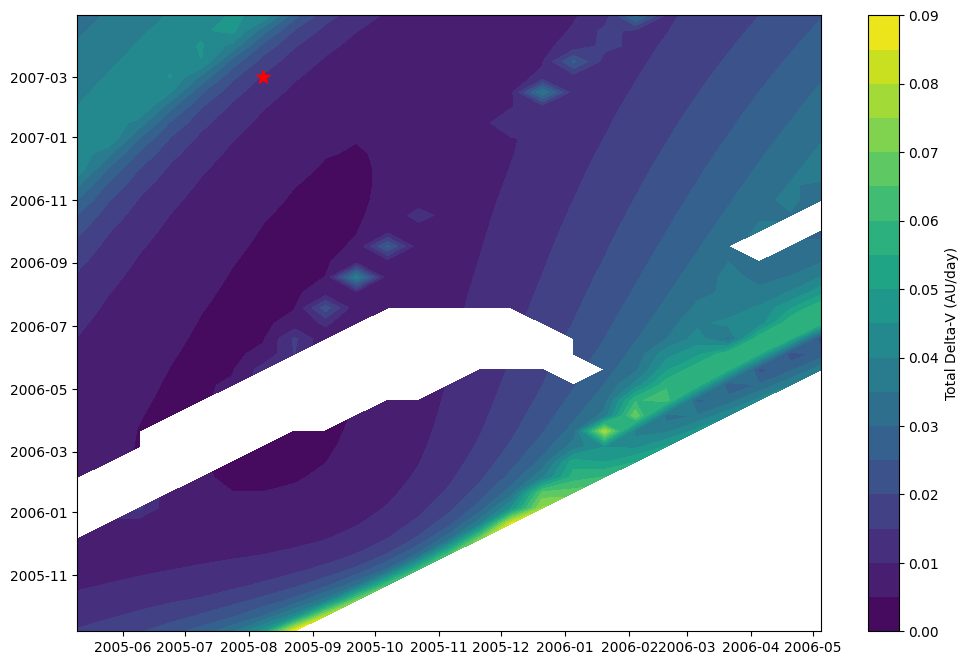

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Convert MJD to datetime for better plotting
def mjd_to_datetime(mjd):
    # MJD 0 corresponds to November 17, 1858
    return datetime(1858, 11, 17) + timedelta(days=mjd)

departure_dates = [mjd_to_datetime(mjd) for mjd in departure_times]
arrival_dates = [mjd_to_datetime(mjd) for mjd in arrival_times]

# Create a meshgrid for contour plotting
X, Y = np.meshgrid(departure_dates, arrival_dates)
Z = dv_total.T  # Transpose for correct orientation

# Create the contour plot
plt.figure(figsize=(12, 8))
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Total Delta-V (AU/day)')

# Mark the minimum delta-v point
best_departure_date = mjd_to_datetime(best_departure)
best_arrival_date = mjd_to_datetime(best_arrival)
plt.scatter(best_departure_date, best_arrival_date, color='red', s=100, marker='*', 
            label=f'Minimum ΔV: {dv_total[min_idx]:.4f} AU/day')

# Add time of flight contours
tof_levels = [120, 180, 240, 300, 360, 420]
X_tof, Y_tof = np.meshgrid(departure_times, arrival_times)
Z_tof = Y_tof - X_tof  # Time of flight in days
CS = plt.contour(X, Y, Z_tof.T, levels=tof_levels, colors='white', linestyles='dashed')
plt.clabel(CS, inline=True, fontsize=10, fmt='%d days')

# Format the plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.xlabel('Earth Departure Date')
plt.ylabel('Mars Arrival Date')
plt.title('Earth-Mars Transfer Porkchop Plot')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()

In [37]:
Z

array([[1312.81140187, 1101.78807387,  879.42773733, ...,           nan,
                  nan,           nan],
       [1190.18194872,  982.82419918,  779.13456173, ...,           nan,
                  nan,           nan],
       [1111.95295795,  914.62863941,  725.50666164, ...,           nan,
                  nan,           nan],
       ...,
       [4164.54550075, 3904.27403368, 3657.40591826, ..., 3222.45935659,
        3190.0488675 , 3087.16996079],
       [3876.27281987, 3623.3170804 , 3382.75715184, ..., 3000.91632013,
        2959.48635403, 2849.95480625],
       [3599.00417765, 3352.75830015, 3117.60124066, ..., 2792.76398073,
        2743.90224768, 2629.24257064]])